In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import evalml
import woodwork as ww
from evalml import AutoMLSearch
from evalml.model_understanding.metrics import graph_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import os

import warnings

/Users/Michael_Enudi/opt/anaconda3/envs/alteryx/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/Michael_Enudi/opt/anaconda3/envs/alteryx/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for de

### Dataset

In [2]:
label = 'is_promoted'
data = pd.read_csv('../../data/employee_promotion.csv')
print(data.shape)
data.head()

(54808, 13)


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,49.0,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,60.0,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,50.0,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,50.0,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,73.0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  awards_won            54808 non-null  int64  
 11  avg_training_score    52248 non-null  float64
 12  is_promoted           54808 non-null  int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 5.4+ MB


In [4]:
print(data[label].value_counts())

0    50140
1     4668
Name: is_promoted, dtype: int64


In [5]:
# remove not required column for this exercise
data.drop(columns=['employee_id'], axis=1, inplace=True)

In [6]:
categorical_values = [col for col in data.columns if data[col].dtype == 'object']
data[categorical_values].nunique()

department              9
region                 34
education               3
gender                  2
recruitment_channel     3
dtype: int64

### Dealing with NAs

In [7]:
data.isnull().sum()

department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
awards_won                 0
avg_training_score      2560
is_promoted                0
dtype: int64

In [8]:
data.education.value_counts()

Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

Because we have a case of employees with imcomplete data, we should look to exclude these from the promotion exercise.
That said, is it possible to see other info for these employees to be excluded

In [9]:
exc_employees = data.loc[data.isna().sum(axis=1) != 0, :]
print(exc_employees.shape)

exc_employees.head()

(8428, 12)


,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
10,Technology,region_23,NaN,m,sourcing,1,30,NaN,1,0,77.0,0
21,Operations,region_15,NaN,m,sourcing,1,41,4.0,11,0,57.0,0
23,Procurement,region_5,Bachelor's,m,other,1,27,NaN,1,0,70.0,0
29,Sales & Marketing,region_4,Bachelor's,m,sourcing,1,26,NaN,1,0,44.0,0
31,Finance,region_31,Bachelor's,m,other,2,26,1.0,2,0,NaN,0


<Axes: xlabel='length_of_service', ylabel='Count'>

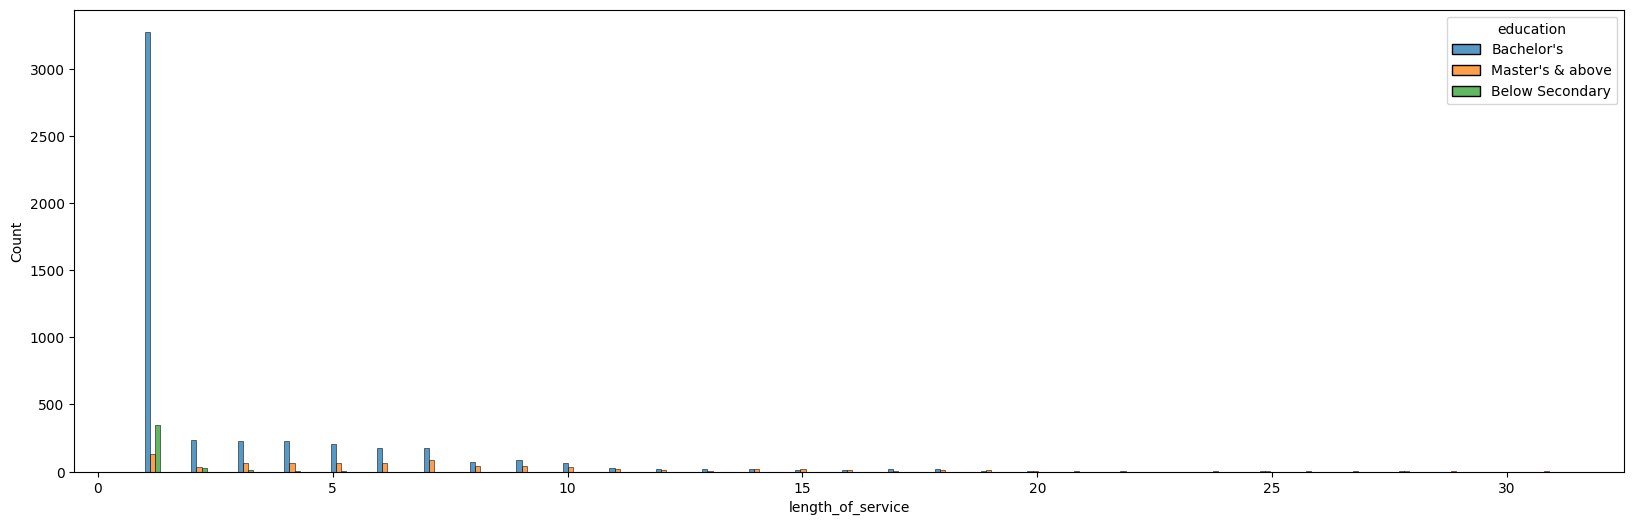

In [10]:
# na columns are education, previous_year_rating and avg_training_score
fig, ax = plt.subplots(figsize=(20, 6))
sns.histplot(exc_employees, x='length_of_service', hue='education', multiple="dodge", ax=ax)

In [11]:
# assign 0 for previous_years_rating all employees that are just a year in service, 
# didn't have previous_year_rating and have their education data available
data.loc[(data['length_of_service'] == 1) & (data['previous_year_rating'].isna()) & (data['education'].notna()), :] = 0
data.isna().sum()

department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating     385
length_of_service          0
awards_won                 0
avg_training_score      2377
is_promoted                0
dtype: int64

In [12]:
exc_employees = data.loc[data.isna().sum(axis=1) != 0, :]
print(exc_employees.shape)

exc_employees.head()

(4689, 12)


,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
10,Technology,region_23,NaN,m,sourcing,1,30,NaN,1,0,77.0,0
21,Operations,region_15,NaN,m,sourcing,1,41,4.0,11,0,57.0,0
31,Finance,region_31,Bachelor's,m,other,2,26,1.0,2,0,NaN,0
32,Sales & Marketing,region_7,NaN,f,sourcing,1,24,1.0,2,0,48.0,0
43,Sales & Marketing,region_2,NaN,m,other,3,24,2.0,2,0,48.0,0


<Axes: xlabel='length_of_service', ylabel='Count'>

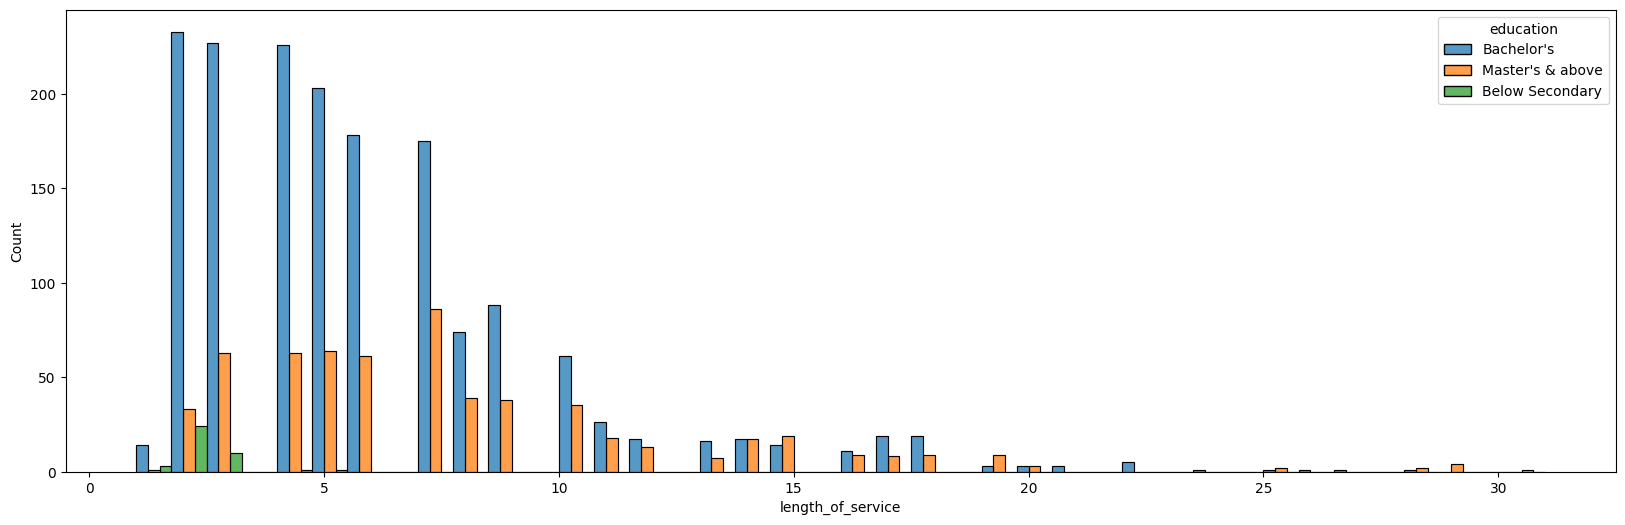

In [13]:
# na columns are education, previous_year_rating and avg_training_score
fig, ax = plt.subplots(figsize=(20, 6))
sns.histplot(exc_employees, x='length_of_service', hue='education', multiple="dodge", ax=ax)

In [14]:
# except for getting better data, we will drop all other nulls.
data = data.dropna()

### Data Analysis

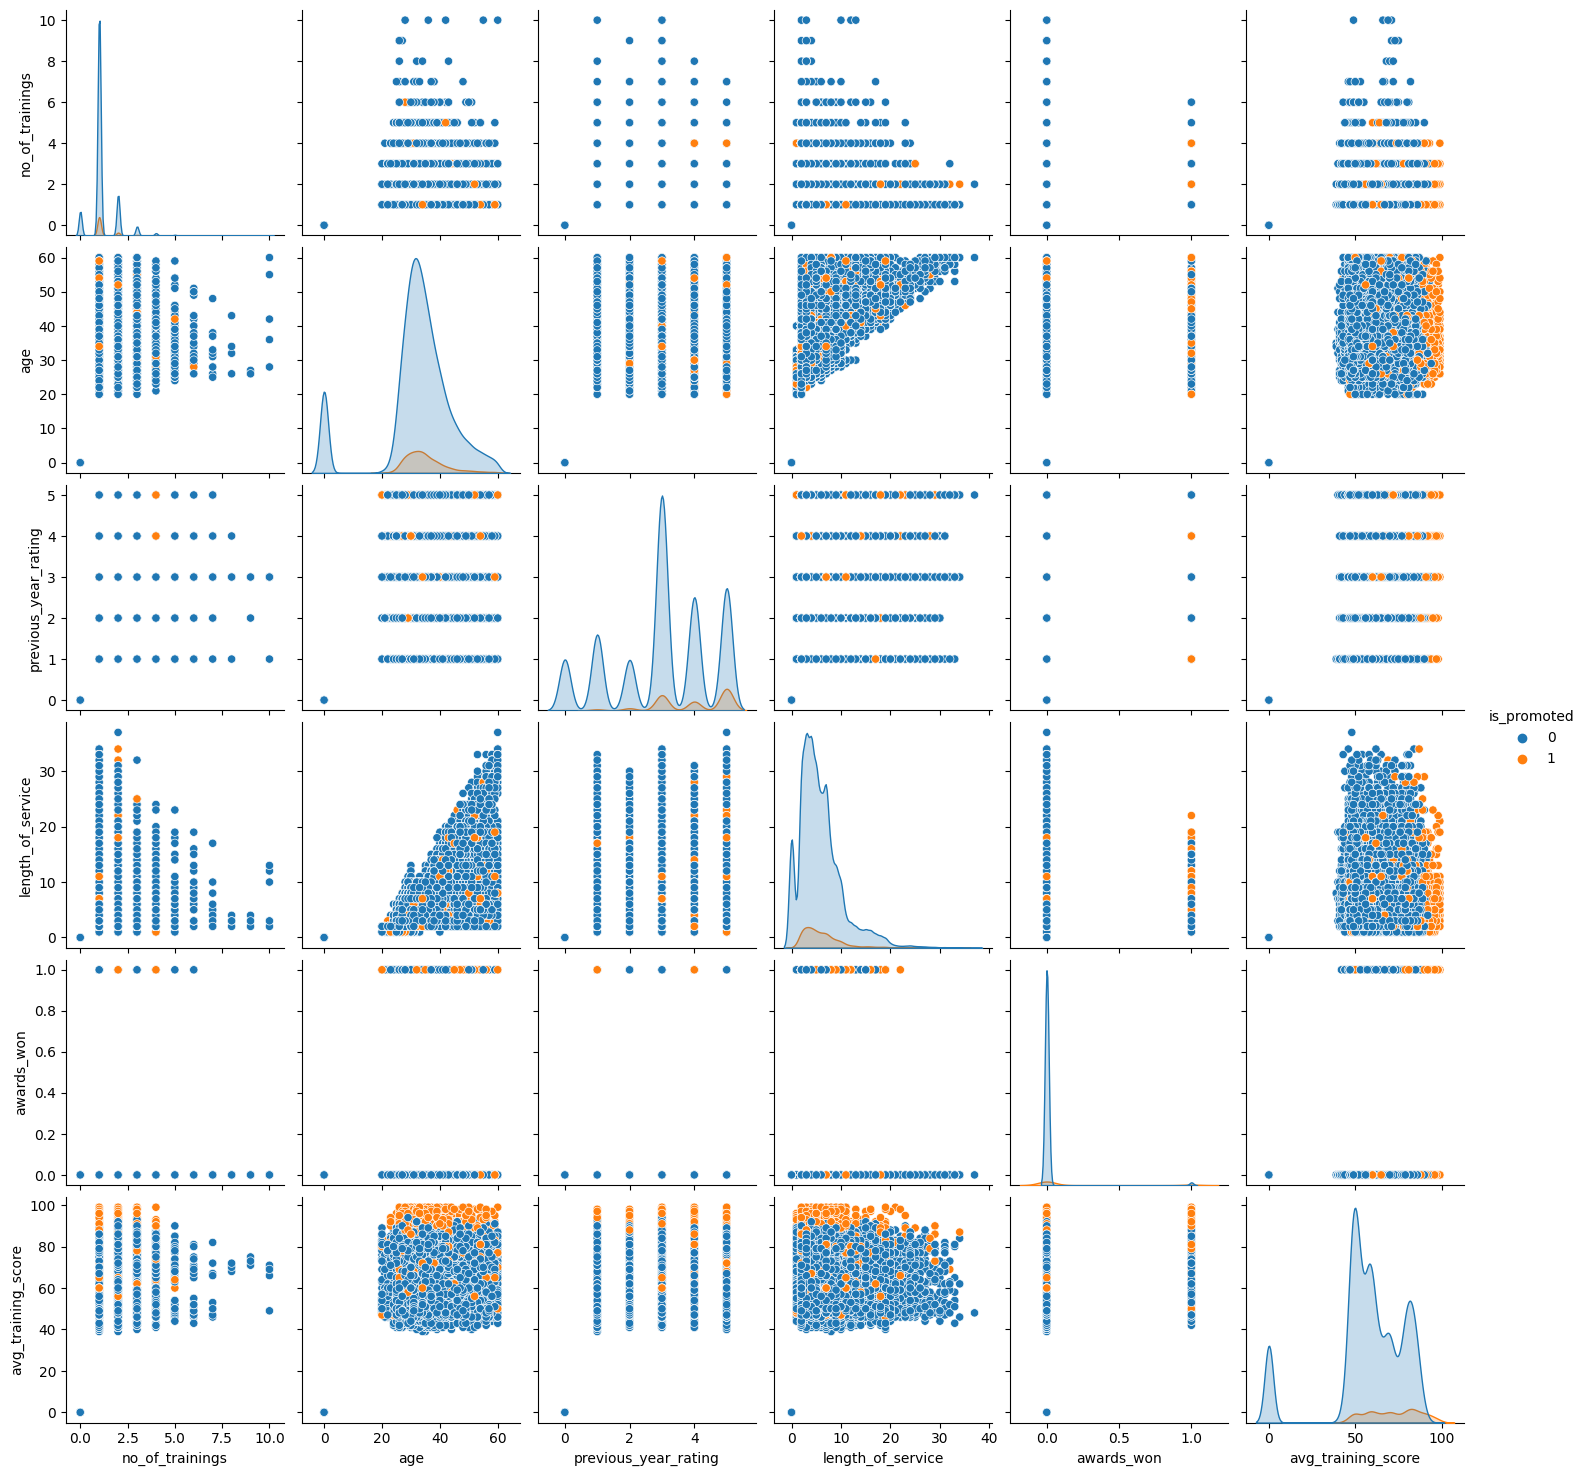

In [15]:
sns.pairplot(data, hue=label)

### Create splits

In [21]:
data.ww.init(name='employee_evaluation')
data.ww.set_types(
    {
        "department": "Categorical", 
        "region": "Categorical", 
        "education": "Categorical", 
        "gender": "Categorical", 
        "recruitment_channel": "Categorical", 
        "no_of_trainings": "IntegerNullable", 
        "age": "Integer", 
        "previous_year_rating": "Double",
        "length_of_service" : "Integer",
        "awards_won" : "Integer",
        "avg_training_score" : "Double",
        label : "Integer"
    }
)

In [22]:
def do_splits(df):
    X = df.drop(columns=[label])
    y = df[label]
    return train_test_split(X, y, test_size=0.20, shuffle=True, random_state=10)

train_X, test_X, train_y, test_y = do_splits(data)
print(f'train_X shape is {train_X.shape}')
print(f'train_y shape is {train_y.shape}')
print(f'test_X shape is {test_X.shape}')
print(f'test_y shape is {test_y.shape}')


train_X shape is (40095, 11)
train_y shape is (40095,)
test_X shape is (10024, 11)
test_y shape is (10024,)


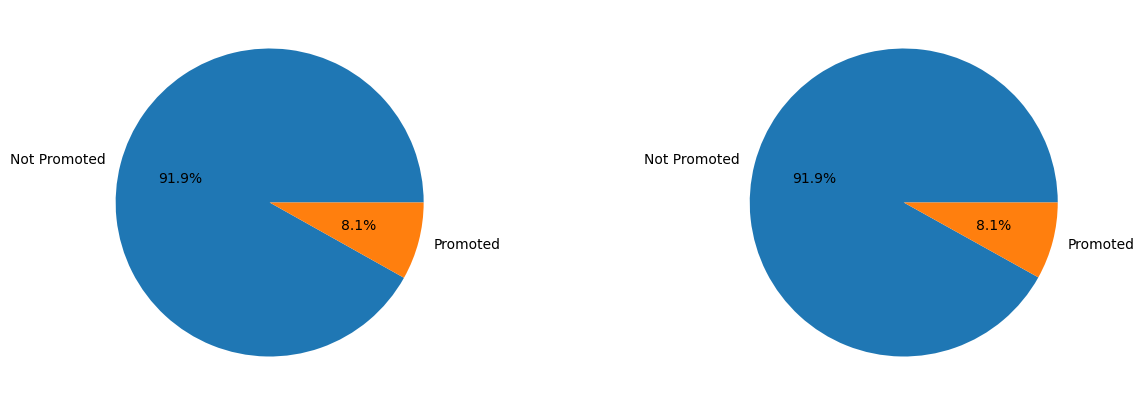

In [29]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

pie_labels = ['Not Promoted', 'Promoted']
training_dist = train_y.value_counts()
testing_dist = test_y.value_counts()
axs[0].pie(training_dist, labels=pie_labels, autopct='%1.1f%%')
axs[1].pie(testing_dist, labels=pie_labels, autopct='%1.1f%%')

plt.show()

# ax.pie(sizes, labels=labels)

### AutoML traiing with EvalML

In [30]:
automl = AutoMLSearch(
    X_train=train_X,
    y_train=train_y,
    problem_type="binary",
    objective='precision',                     # shocking, I did better commenting out these lines
    additional_objectives=["auc", "f1"],
#     max_batches=3,
#     optimize_thresholds=True,
    verbose=True,
)

automl.search(interactive_plot=True)

AutoMLSearch will use mean CV score to rank pipelines.
Using default limit of max_batches=3.


*****************************
* Beginning pipeline search *
*****************************

Optimizing for Precision. 
Greater score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 3 batches for a total of None pipelines. 
Allowed model families: 



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type': 'scatter',
              'uid': 'b247db7b-7a90-4ea4-a552-1472b9fb0503',
              'x': [],
              'y': []},
             {'marker': {'color': 'gray'},
              'mode': 'markers',
              'name': 'Iter score',
              'type': 'scatter',
              'uid': '261a8377-17ec-42bf-b8e1-ab7e04c3748d',
              'x': [],
              'y': []}],
    'layout': {'showlegend': False,
               'template': '...',
               'title': {'text': ('Pipeline Search: Iteration vs.' ... 'ore at current iteration</sub>')},
               'xaxis': {'rangemode': 'tozero', 'title': {'text': 'Iteration'}},
               'yaxis': {'title': {'text': 'Validation Score'}}}
})

Exception: An exception occurred while trying to import `lightgbm`: dlopen(/Users/Michael_Enudi/opt/anaconda3/envs/alteryx/lib/python3.9/site-packages/lightgbm/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: <D21A7969-4567-3BC7-94ED-6A9E83AE9D78> /Users/Michael_Enudi/opt/anaconda3/envs/alteryx/lib/python3.9/site-packages/lightgbm/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file, not in dyld cache)